In [1]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
from numpy import linspace
import xgboost as xgb
import seaborn as sns
from xgboost.sklearn import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.style as style
from sklearn.metrics import confusion_matrix
import warnings


sys.path.append('../../vscreenml/') #This let you access my module from any where
from configuration import figures_config as cfg
from utilities import figureutilities


%matplotlib inline 
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True'
target = 'Label'
IDcol = 'Name'

/Users/yusufadeshina/miniconda2/envs/rdkit_env/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
target

'Label'

In [3]:
style.use('seaborn-white')
#style.available  (to see the styles available)

In [4]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

### PPI Benchmark

In [5]:
#PPI target not present in our training set
ppi_tag = ['1PW6','1R6N','1Y2F','2AZ5','2KP8','3IN7','3O5N','3VKX','3ZRC','4G55']

In [6]:
rank_dict = {}
for score in ['nnscore','rfscore_v1','rfscore_v3','rfscore_v2',
                'PLEClinear_p5_l1_s65536','PLECnn_p5_l1_s65536',
                  'PLECrf_p5_l1_s65536']:
    print ('||||||||||||||||||||||||||||||Processing',score,'|||||||||||||||||||||||||||||||||||||',"\n")
    rank_list_other={}
    for i in ppi_tag:
        ifile = cfg.PAPER_FIGURE_DIR+'/ppi/final_'+str(i)+'_all_rf_vina_random2000.csv'
        compounds_list2 = pd.read_csv(ifile, encoding="utf-8-sig",delimiter=' ')
        rank_other= figureutilities.predict_rank_active_other_ppi(compounds_list2,score,ifile)
        rank_list_other[i] = rank_other
    #print np.mean(rank_list_other),"+/-",np.std(rank_list_other)
    rank_dict[score] = rank_list_other
df_vina_others = pd.DataFrame.from_dict(rank_dict)    

||||||||||||||||||||||||||||||Processing nnscore ||||||||||||||||||||||||||||||||||||| 

Rank for the active native ligand /Users/yusufadeshina/vscreenml/paper_figure/ppi/final_1PW6_all_rf_vina_random2000.csv is 30
Rank for the active native ligand /Users/yusufadeshina/vscreenml/paper_figure/ppi/final_1R6N_all_rf_vina_random2000.csv is 205
Rank for the active native ligand /Users/yusufadeshina/vscreenml/paper_figure/ppi/final_1Y2F_all_rf_vina_random2000.csv is 1823
Rank for the active native ligand /Users/yusufadeshina/vscreenml/paper_figure/ppi/final_2AZ5_all_rf_vina_random2000.csv is 1905
Rank for the active native ligand /Users/yusufadeshina/vscreenml/paper_figure/ppi/final_2KP8_all_rf_vina_random2000.csv is 1616
Rank for the active native ligand /Users/yusufadeshina/vscreenml/paper_figure/ppi/final_3IN7_all_rf_vina_random2000.csv is 1650
Rank for the active native ligand /Users/yusufadeshina/vscreenml/paper_figure/ppi/final_3O5N_all_rf_vina_random2000.csv is 1996
Rank for the activ

In [7]:
print ('||||||||||||||||||||||||||||||Processing RFSCORE VS |||||||||||||||||||||||||||||||||||||',"\n")

rank_dict_rfscorevs={}
for i in ppi_tag:
    ifile = cfg.PAPER_FIGURE_DIR+'/ppi/final_'+str(i)+'_rfscorevs_random2000full.csv'
    
    compounds_list2 = pd.read_csv(ifile, encoding="utf-8-sig")
    rank_other=figureutilities.predict_rank_active_rf_ppi(compounds_list2,ifile)
    rank_dict_rfscorevs[i] = rank_other
df_rfscorevs = pd.DataFrame.from_dict({"rfscorevs":rank_dict_rfscorevs})
#df_rfscorevs.rename(columns={"0": "rfscorevs"})
#print np.mean(rank_list_rfscorevs),"+/-",np.std(rank_list_rfscorevs)

||||||||||||||||||||||||||||||Processing RFSCORE VS ||||||||||||||||||||||||||||||||||||| 

Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/final_1PW6_rfscorevs_random2000full.csv is 1289
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/final_1R6N_rfscorevs_random2000full.csv is 308
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/final_1Y2F_rfscorevs_random2000full.csv is 1528
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/final_2AZ5_rfscorevs_random2000full.csv is 83
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/final_2KP8_rfscorevs_random2000full.csv is 420
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/final_3IN7_rfscorevs_random2000full.csv is 308
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/final_3O5N_rfscorevs_random200

In [8]:
with open(cfg.VSCREENML+'/model/XGB_CLASSIFIER_alldata.pickle.dat', 'rb') as f:
    clf = pickle.load(f)

In [9]:
print ('||||||||||||||||||||||||||||||Processing vScreenML|||||||||||||||||||||||||||||||||||||',"\n")

rank_dict_vscreenml={}
for i in ppi_tag:
    ifile = cfg.PAPER_FIGURE_DIR+'/ppi/'+str(i)+'_combined_random2000.csv'
    compounds_list2 = pd.read_csv(ifile, encoding="utf-8-sig")
    predictors = [x for x in compounds_list2.columns if x not in [target, IDcol]]
    rank_other=figureutilities.predict_rank_vscreenml_ppi(clf,compounds_list2,predictors,ifile)
    rank_dict_vscreenml[i]=rank_other
df_vscreenml = pd.DataFrame.from_dict({"vScreenML":rank_dict_vscreenml})

||||||||||||||||||||||||||||||Processing vScreenML||||||||||||||||||||||||||||||||||||| 

Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/1PW6_combined_random2000.csv is 3
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/1R6N_combined_random2000.csv is 922
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/1Y2F_combined_random2000.csv is 42
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/2AZ5_combined_random2000.csv is 179
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/2KP8_combined_random2000.csv is 148
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/3IN7_combined_random2000.csv is 10
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/3O5N_combined_random2000.csv is 51
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/

In [10]:
print ('||||||||||||||||||||||||||||||Processing Rosetta|||||||||||||||||||||||||||||||||||||',"\n")
rank_dict_rosetta={}
for i in ppi_tag:
    ifile = cfg.PAPER_FIGURE_DIR+'/ppi/'+str(i)+'_rosetta_random2000full.csv'
    compounds_list2 = pd.read_csv(ifile, encoding="utf-8-sig",sep=' ')
    #print compounds_list2.columns
    rank_other=figureutilities.predict_rank_active_rosetta_ppi(compounds_list2,'Interface_Energy',ifile,True)
    rank_dict_rosetta[i] = rank_other
df_rosetta = pd.DataFrame.from_dict({"Rosetta":rank_dict_rosetta})
#print np.mean(rank_list_rosetta),"+/-",np.std(rank_list_rosetta)

||||||||||||||||||||||||||||||Processing Rosetta||||||||||||||||||||||||||||||||||||| 

Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/1PW6_rosetta_random2000full.csv is 13
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/1R6N_rosetta_random2000full.csv is 812
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/1Y2F_rosetta_random2000full.csv is 675
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/2AZ5_rosetta_random2000full.csv is 320
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/2KP8_rosetta_random2000full.csv is 1108
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/3IN7_rosetta_random2000full.csv is 61
Rank for the active native ligand in /Users/yusufadeshina/vscreenml/paper_figure/ppi/3O5N_rosetta_random2000full.csv is 1038
Rank for the active native ligand in /Users/

In [11]:
pd_rank = pd.concat((df_vscreenml,df_rosetta,df_vina_others,df_rfscorevs),axis=1)

In [12]:
pd_rank

,vScreenML,Rosetta,nnscore,rfscore_v1,rfscore_v3,rfscore_v2,PLEClinear_p5_l1_s65536,PLECnn_p5_l1_s65536,PLECrf_p5_l1_s65536,rfscorevs
1PW6,2,12,29,102,145,92,635,532,228,1288
1R6N,921,811,204,513,240,242,30,4,43,307
1Y2F,41,674,1822,333,511,250,305,736,474,1527
2AZ5,178,319,1904,282,628,249,558,629,1144,82
2KP8,147,1107,1615,740,1145,1534,1337,273,144,419
3IN7,9,60,1649,613,436,762,1637,1215,1309,307
3O5N,50,1037,1995,1847,1918,1813,1677,934,1029,494
3VKX,33,1251,1985,1966,1919,1970,1637,1610,1403,1146
3ZRC,640,1700,1982,1914,1896,1981,1875,1873,1901,55
4G55,888,1167,1347,1544,1515,1832,815,1708,1754,1912


In [13]:
#for publication quality plotting in prism
pd_rank.to_csv(cfg.PAPER_FIGURE_DIR+'/ppi/ppi_benchmark_full_no_overlap_with_out_training_set.csv')

In [14]:
columns = ['PLEClinear_p5_l1_s65536','PLECnn_p5_l1_s65536','PLECrf_p5_l1_s65536','nnscore','rfscore_v1','rfscore_v2','rfscore_v3','rfscorevs','Rosetta']

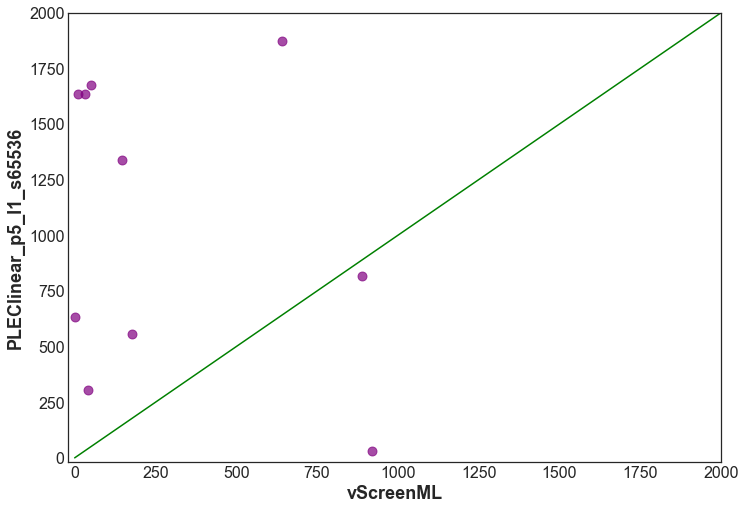

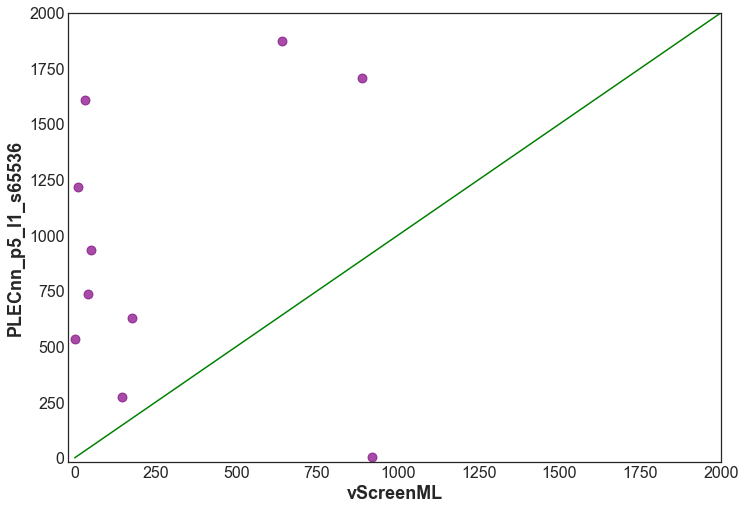

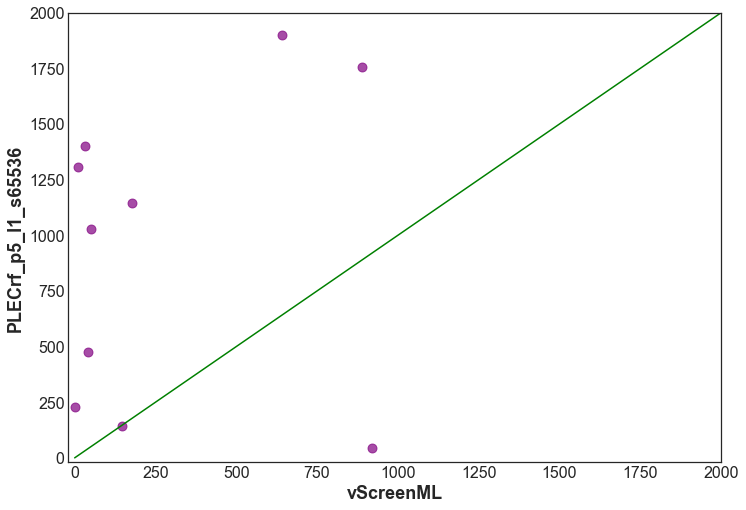

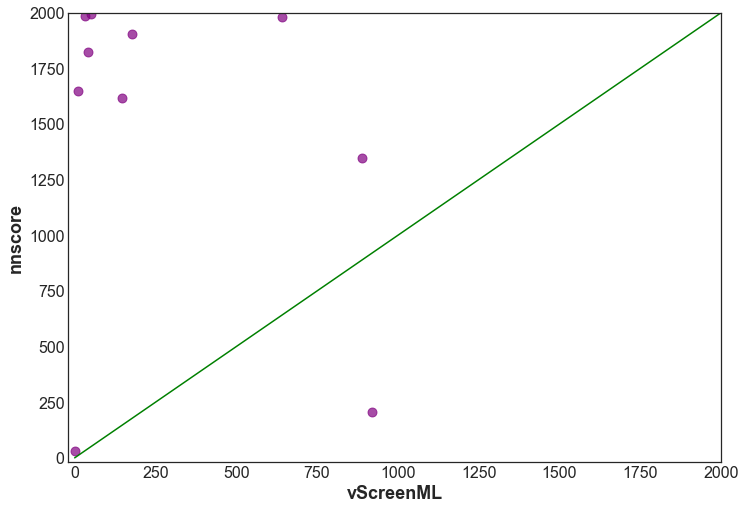

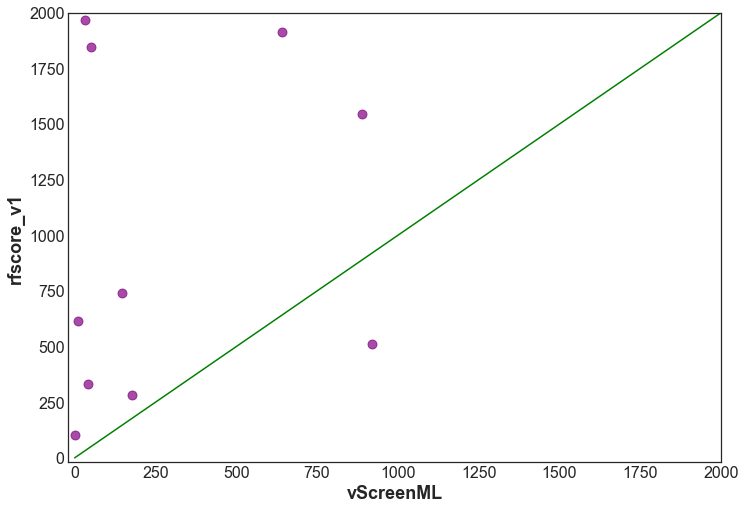

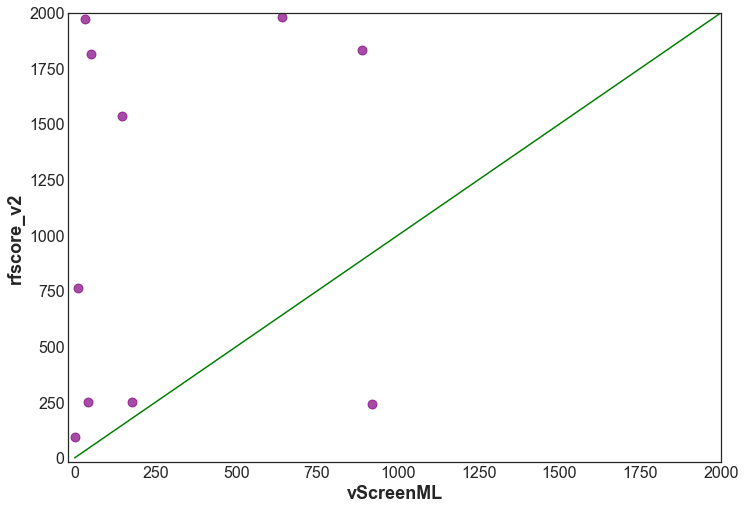

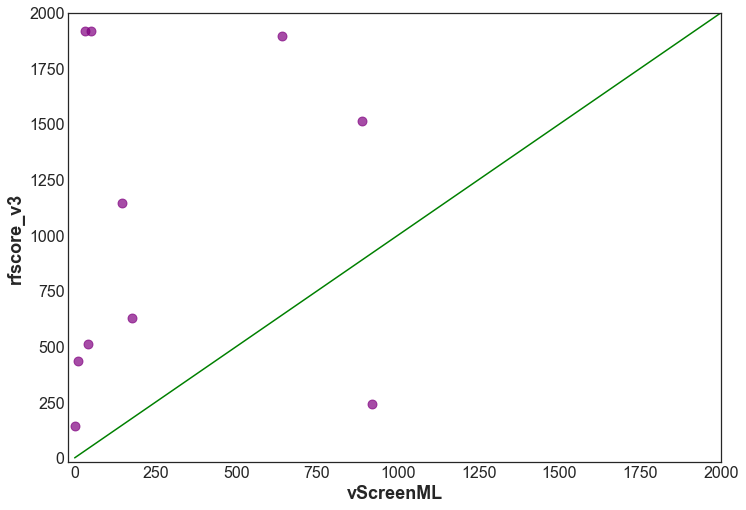

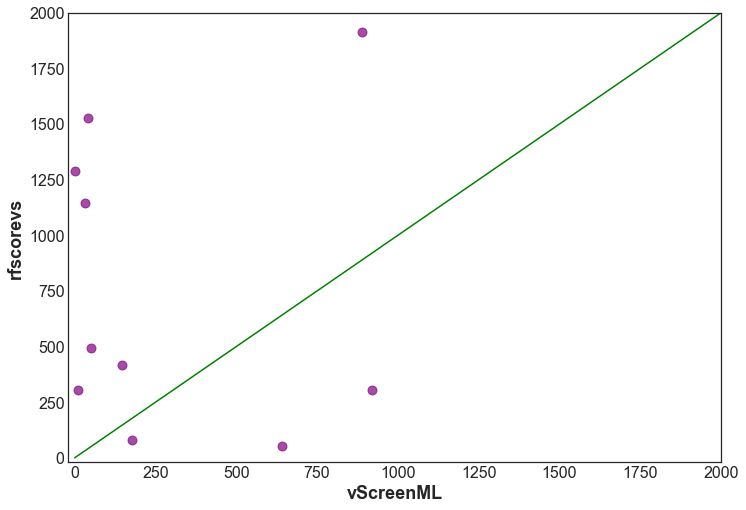

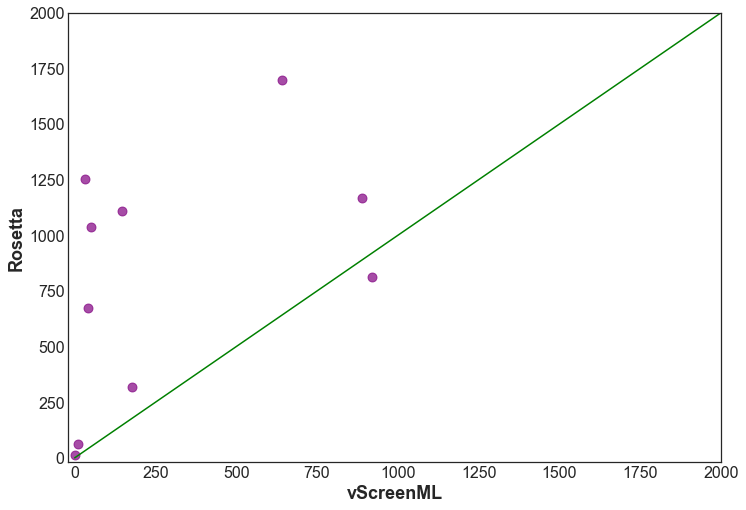

In [15]:
for column in columns:
    figureutilities.plot_benchmark_graph_ppi(pd_rank, 'vScreenML',column)

### DEKOIS BENCHMARK

In [18]:
#proteins that are not present in D-COID
tag_no_train = ['11betaHSD1',
'17betaHSD1',
'A2A',
'ACE',
'ACE2',
'ADAM17',
'ADRB2',
'BCL2',
'COX1',
'CYP2A6',
'GBA',
'GR',
'HMGR',
'MMP2',
'PDE5',
'PNP',
'QPCT',
'ROCK-1',
'SARS-HCoV',
'TIE2',
'TK',
'TP',
'VEGFR1']

In [19]:
enrich_dict ={}
for ifile in tag_no_train:
    compounds_list = pd.read_csv(cfg.PAPER_FIGURE_DIR+'/dekois/'+ifile+'_full_set_of_all_scoring_function.csv', encoding="utf-8-sig")
    scores = ['nnscore','rfscore_v1','rfscore_v3','rfscore_v2','PLEClinear_p5_l1_s65536','PLECnn_p5_l1_s65536','PLECrf_p5_l1_s65536','vina_affinity','rfscorevs']
    predictors = [x for x in compounds_list.columns if x not in [target, IDcol] and x not in scores]
    enrich_dict[ifile] = figureutilities.predict_1percent_enrichment_dekois(clf, compounds_list, predictors,scores )

In [20]:
enrich_df = pd.DataFrame.from_dict(enrich_dict,orient='index')

In [21]:
enrich_df

,nnscore,rfscore_v1,rfscore_v3,rfscore_v2,PLEClinear_p5_l1_s65536,PLECnn_p5_l1_s65536,PLECrf_p5_l1_s65536,vina_affinity,rfscorevs,vScreenML,Interface_Energy
11betaHSD1,2.868421,0.000000,2.868421,0.000000,0.000000,0.000000,0.000000,2.868421,0.000000,8.605263,0.000000
17betaHSD1,2.708625,0.000000,0.000000,0.000000,0.000000,2.708625,0.000000,0.000000,2.708625,5.417249,0.000000
A2A,0.000000,0.000000,5.145299,5.145299,7.717949,2.572650,5.145299,0.000000,15.435897,7.717949,0.000000
ACE,13.363636,0.000000,0.000000,5.345455,0.000000,2.672727,0.000000,10.690909,2.672727,21.381818,2.672727
ACE2,2.693182,10.772727,13.465909,5.386364,0.000000,0.000000,0.000000,5.386364,0.000000,8.079545,8.079545
ADAM17,0.000000,2.718182,2.718182,0.000000,0.000000,2.718182,2.718182,8.154545,13.590909,2.718182,5.436364
ADRB2,2.500000,0.000000,0.000000,0.000000,0.000000,2.500000,0.000000,2.500000,0.000000,0.000000,0.000000
BCL2,0.000000,13.857809,19.400932,16.629371,2.771562,2.771562,2.771562,8.314685,5.543124,5.543124,2.771562
COX1,2.706818,0.000000,0.000000,0.000000,0.000000,8.120455,0.000000,2.706818,18.947727,10.827273,0.000000
CYP2A6,2.710526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
enrich_df.to_csv(cfg.PAPER_FIGURE_DIR+'/dekois/enrichment_one_percent_dekois.csv')

#### More Detailed Investigations rfscorevs

In [23]:
##Exclude target from both vScreenML and rfscorevs
tags_exclude = [#'11betaHSD1',
'17betaHSD1',
#'A2A',
#'ACE',
'ACE2',
#'ADAM17',
#'ADRB2',
#'ADRB2',
'BCL2',
#'COX1',
'CYP2A6',
#'GBA',
#'GR',
#'HMGR',
'MMP2',
#'PDE5',
#'PNP',
'QPCT',
#'ROCK-1',
'SARS-HCoV',
'TIE2',
#'TK',
'TP',
'VEGFR1']

In [24]:
#target from dekois that are also present in training set of rfscorevs
tags_overlap = ['11betaHSD1',
'A2A',
'ACE',
'ADAM17',
'ADRB2',
'ADRB2',
'COX1',
'GBA',
'GR',
'HMGR',
'PDE5',
'PNP',
'ROCK-1',
'TK']

In [25]:
df_enrich_exlcude_common = enrich_df[enrich_df.index.isin(tags_exclude)]

In [26]:
df_enrich_exlcude_common

,nnscore,rfscore_v1,rfscore_v3,rfscore_v2,PLEClinear_p5_l1_s65536,PLECnn_p5_l1_s65536,PLECrf_p5_l1_s65536,vina_affinity,rfscorevs,vScreenML,Interface_Energy
17betaHSD1,2.708625,0.000000,0.000000,0.000000,0.000000,2.708625,0.000000,0.000000,2.708625,5.417249,0.000000
ACE2,2.693182,10.772727,13.465909,5.386364,0.000000,0.000000,0.000000,5.386364,0.000000,8.079545,8.079545
BCL2,0.000000,13.857809,19.400932,16.629371,2.771562,2.771562,2.771562,8.314685,5.543124,5.543124,2.771562
CYP2A6,2.710526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MMP2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.510417,0.000000,0.000000,2.510417,0.000000
QPCT,0.000000,0.000000,0.000000,5.426573,10.853147,10.853147,2.713287,0.000000,0.000000,0.000000,0.000000
SARS-HCoV,0.000000,0.000000,0.000000,0.000000,3.041322,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TIE2,5.128205,5.128205,7.692308,2.564103,7.692308,2.564103,15.384615,7.692308,7.692308,5.128205,2.564103
TP,5.590909,0.000000,0.000000,5.590909,2.795455,2.795455,0.000000,5.590909,16.772727,0.000000,0.000000
VEGFR1,0.000000,5.132479,0.000000,5.132479,0.000000,0.000000,7.698718,7.698718,15.397436,10.264957,0.000000


In [27]:
df_enrich_common = enrich_df[enrich_df.index.isin(tags_overlap)]

In [28]:
df_enrich_common

,nnscore,rfscore_v1,rfscore_v3,rfscore_v2,PLEClinear_p5_l1_s65536,PLECnn_p5_l1_s65536,PLECrf_p5_l1_s65536,vina_affinity,rfscorevs,vScreenML,Interface_Energy
11betaHSD1,2.868421,0.000000,2.868421,0.000000,0.000000,0.000000,0.000000,2.868421,0.000000,8.605263,0.000000
A2A,0.000000,0.000000,5.145299,5.145299,7.717949,2.572650,5.145299,0.000000,15.435897,7.717949,0.000000
ACE,13.363636,0.000000,0.000000,5.345455,0.000000,2.672727,0.000000,10.690909,2.672727,21.381818,2.672727
ADAM17,0.000000,2.718182,2.718182,0.000000,0.000000,2.718182,2.718182,8.154545,13.590909,2.718182,5.436364
ADRB2,2.500000,0.000000,0.000000,0.000000,0.000000,2.500000,0.000000,2.500000,0.000000,0.000000,0.000000
COX1,2.706818,0.000000,0.000000,0.000000,0.000000,8.120455,0.000000,2.706818,18.947727,10.827273,0.000000
GBA,0.000000,0.000000,2.574786,2.574786,0.000000,0.000000,0.000000,0.000000,0.000000,2.574786,2.574786
GR,2.710956,8.132867,5.421911,2.710956,0.000000,0.000000,5.421911,5.421911,10.843823,5.421911,0.000000
HMGR,2.729604,0.000000,2.729604,5.459207,2.729604,2.729604,2.729604,2.729604,27.296037,24.566434,8.188811
PDE5,0.000000,0.000000,2.704545,0.000000,10.818182,8.113636,2.704545,2.704545,5.409091,8.113636,0.000000


In [29]:
figureutilities.wilcoxon_signed(df_enrich_exlcude_common['rfscorevs'], df_enrich_exlcude_common['vScreenML'])

Statistics=9.000, p=0.75315
Same distribution (fail to reject H0)


In [30]:
figureutilities.wilcoxon_signed(df_enrich_common['rfscorevs'], df_enrich_common['vScreenML'])

Statistics=27.000, p=0.34652
Same distribution (fail to reject H0)


### P-values

##### DEKOIS

In [31]:
columns = [i for i in enrich_df.columns if i not in ['Name']]
seen = []
for i in columns:
    for j in columns:
        if i != j:
            print ('|||||||||||||||Comapring ' + i +' and '+ j+ '\t|||||||||||||||||||||||') 
            figureutilities.wilcoxon_signed(enrich_df[i], enrich_df[j])
            print ('||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||\n') 

|||||||||||||||Comapring nnscore and rfscore_v1	|||||||||||||||||||||||
Statistics=56.000, p=0.82028
Same distribution (fail to reject H0)
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

|||||||||||||||Comapring nnscore and rfscore_v3	|||||||||||||||||||||||
Statistics=45.000, p=0.39425
Same distribution (fail to reject H0)
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

|||||||||||||||Comapring nnscore and rfscore_v2	|||||||||||||||||||||||
Statistics=55.000, p=0.30879
Same distribution (fail to reject H0)
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

|||||||||||||||Comapring nnscore and PLEClinear_p5_l1_s65536	|||||||||||||||||||||||
Statistics=68.000, p=0.68741
Same distribution (fail to reject H0)
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

|||||||||||||||Comapring nnscore and PLECnn_p5_l1_s65536	|||||||||||||||||||||||
Statistics=52.000, p=0.40804
Same distribution (fail to reject H0)
|||||||||||

### RFSCORE_V1 MODEL FOR OUR DATASET

In [ ]:
def predict_rank_log_roc_1percent_enrichment_other(model_all,model_rf, test_x, predictors,predictors_rf, scores):
    
    random_hit_rate = test_x['Label'].sum()/float(len(test_x['Label']))*100

    
    dtest_pred = model_all.predict_proba(test_x[predictors])[:,1]
    test_x["vScreenML"] = dtest_pred
    
    dtest_pred_rf = model_rf.predict_proba(test_x[predictors_rf])[:,1]
    test_x["RFSCORE_V1_remade"] = dtest_pred_rf

    scores.extend(["vScreenML","Interface_Energy","RFSCORE_V1_remade"])
    

    
    enrichment_dict = {}
    rank_dict = {}
    for score in scores:
        #print (y_test.dtypes, test_x[score].dtypes)
                    
        if score == 'vina_affinity' or score == 'Interface_Energy':
                sort_final = test_x.sort_values(by=score, ascending=True)
                rank=list(sort_final["Label"]).index(1)+1
                #print (sort_final.head())
                one_percent = int (len(sort_final['Name'].tolist()) * 0.01)
                one_percent_df = sort_final.head(one_percent)
                true_positive=float(len(one_percent_df[(one_percent_df.Label == 1)]))
                hit_rate = true_positive/one_percent*100    
                enrichment = hit_rate/random_hit_rate
                enrichment_dict[score] = enrichment
                rank_dict[score] = rank
        else:
                sort_final = test_x.sort_values(by=score, ascending=False)
                rank=list(sort_final["Label"]).index(1)+1
                one_percent = int (len(sort_final['Name'].tolist()) * 0.01)
                one_percent_df = sort_final.head(one_percent)
                true_positive=float(len(one_percent_df[(one_percent_df.Label == 1)]))
                hit_rate = true_positive/one_percent*100    
                enrichment = hit_rate/random_hit_rate
                enrichment_dict[score] = enrichment
                rank_dict[score] = rank
                
    return enrichment_dict, rank_dict

In [ ]:
with open('/Users/yusufadeshina/Downloads/all_ipython_notenook/RFSCORE_V1_RETRAINED_WITH_OUR_DATA.pickle.dat', 'rb') as f:
    clf_rf = pickle.load(f)

In [ ]:
predictors_rf = [
    '6.6','7.6','8.6','16.6','6.7','7.7','8.7','16.7','6.8',
    '7.8','8.8','16.8','6.9','7.9','8.9','16.9','6.15','7.15',
    '8.15','16.15','6.16','7.16','8.16','16.16','6.17','7.17',
    '8.17','16.17','6.35','7.35','8.35','16.35','6.53','7.53',
    '8.53','16.53']

In [ ]:
enrich_dict ={}
for ifile in tags:
    compounds_list = pd.read_csv('/Users/yusufadeshina/Downloads/DEKOIS2.0_library/recombined_result082319/'+ifile+'_full_set_of_all_scoring_function.csv', encoding="utf-8-sig")
    scores = ['RFSCORE_V1_remade', 'nnscore','rfscore_v1','rfscore_v3','rfscore_v2','PLEClinear_p5_l1_s65536','PLECnn_p5_l1_s65536','PLECrf_p5_l1_s65536','vina_affinity','rfscorevs']
    predictors = [x for x in compounds_list.columns if x not in [target, IDcol] and x not in scores]
    enrich_dict[ifile],_ = predict_rank_log_roc_1percent_enrichment_other(clf,clf_rf, compounds_list, predictors,predictors_rf, scores )

In [ ]:
enrich_df = pd.DataFrame.from_dict(enrich_dict,orient='index')

In [ ]:
enrich_df

In [ ]:
columns = [i for i in enrich_df.columns if i not in ['Name']]
seen = []
for i in columns:
    for j in columns:
        if i != j:
            print ('|||||||||||||||Comapring ' + i +' and '+ j+ '\t|||||||||||||||||||||||') 
            wilcoxon_signed(enrich_df[i], enrich_df[j])
            print ('||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||\n') 

In [ ]:
enrich_df.to_csv('/Users/yusufadeshina/utilities_for_goldi_paper/enrichment_one_percentwith_rfscorev1.csv')

##### rank rfscore_v1_remade

In [ ]:
rank_dict ={}
for ifile in unseen_ppi:
    compounds_list = pd.read_csv('/Users/yusufadeshina/Downloads/ppi_benchmark/'+ifile+'_ppi_full_set_of_all_scoring_function.csv', encoding="utf-8-sig")
    scores = ['RFSCORE_V1_remade', 'nnscore','rfscore_v1','rfscore_v3','rfscore_v2','PLEClinear_p5_l1_s65536','PLECnn_p5_l1_s65536','PLECrf_p5_l1_s65536','vina_affinity','rfscorevs']
    predictors = [x for x in compounds_list.columns if x not in [target, IDcol] and x not in scores]
    _, rank_dict[ifile] = predict_rank_log_roc_1percent_enrichment_other(clf,clf_rf, compounds_list, predictors,predictors_rf, scores )

In [ ]:
rank_df = pd.DataFrame.from_dict(rank_dict,orient='index')

In [ ]:
rank_df

In [ ]:
columns = [i for i in rank_df.columns if i not in ['Name']]
seen = []
for i in columns:
    for j in columns:
        if i != j:
            print ('|||||||||||||||Comapring ' + i +' and '+ j+ '\t|||||||||||||||||||||||') 
            wilcoxon_signed(np.log(rank_df[i]), np.log(rank_df[j]))
            print ('||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||\n') 

In [ ]:
rank_df.to_csv('/Users/yusufadeshina/utilities_for_goldi_paper/rank_one_percentwith_rfscorev1.csv')